In [263]:
# VISUALIZATIONS

# Dependencies and Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
from pypfopt import expected_returns, EfficientSemivariance
from pypfopt.base_optimizer import BaseConvexOptimizer
from pypfopt.objective_functions import ex_post_tracking_error
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting
import os
import json
from collections import Counter
from PIL import Image, ImageDraw, ImageFont
from PIL.PngImagePlugin import PngInfo

In [264]:
# Cleaned Weights and Expected Returns Series
with open('data/cleaned_weights.pkl', 'rb') as f:
    cleaned_weights = pickle.load(f)

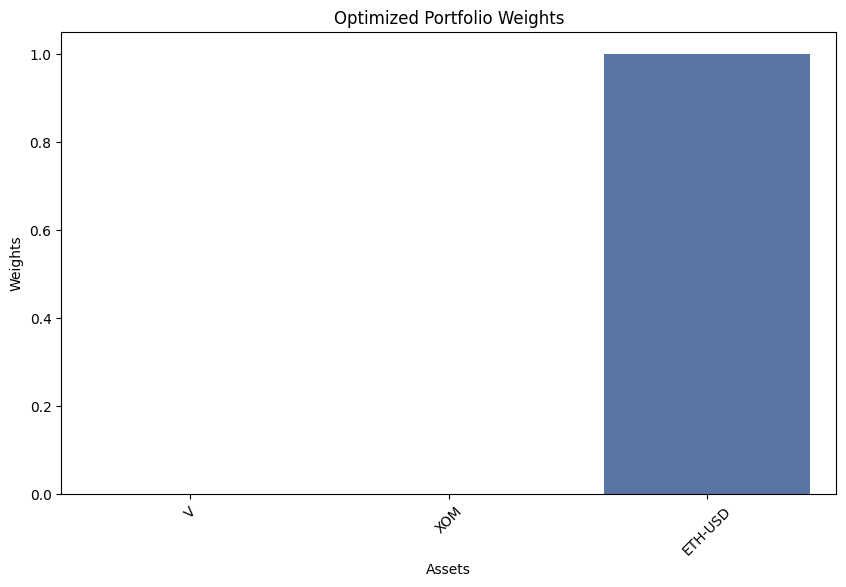

In [265]:
# Optimized Portfolio Weights
plt.figure(figsize=(10, 6))
sns.barplot(x=list(cleaned_weights.keys()), y=list(cleaned_weights.values()))
plt.title('Optimized Portfolio Weights')
plt.xlabel('Assets')
plt.ylabel('Weights')
plt.xticks(rotation=45)
plt.grid(False)
figname = "images/01_OptimizedPortfolioWeights.png"
plt.savefig(figname)
plt.show()

In [266]:
all_data = pd.read_pickle('data/all_data.pkl')

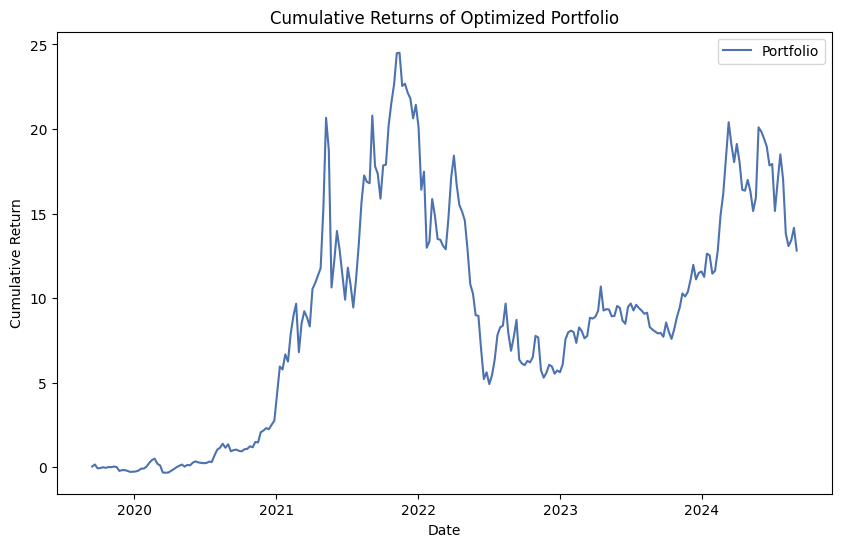

In [267]:
# Cumulative Portfolio Returns
def calculate_portfolio_cumulative_returns(weights, returns_df):
    portfolio_returns = (returns_df * weights).sum(axis=1)
    cumulative_returns = (1 + portfolio_returns).cumprod() - 1
    return cumulative_returns

cumulative_returns = calculate_portfolio_cumulative_returns(cleaned_weights, all_data)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label='Portfolio')
plt.title('Cumulative Returns of Optimized Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(False)
plt.legend()
figname = "images/03_CumulativeReturnsOptimized.png"
plt.savefig(figname)
plt.show()

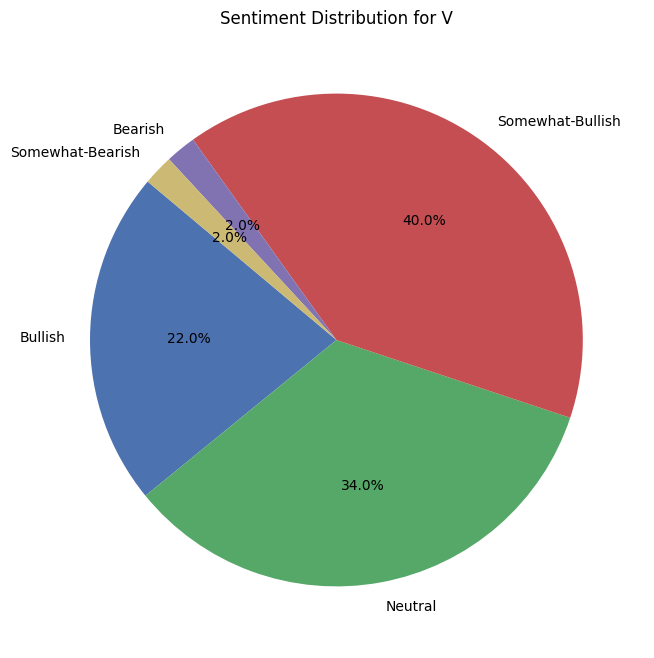

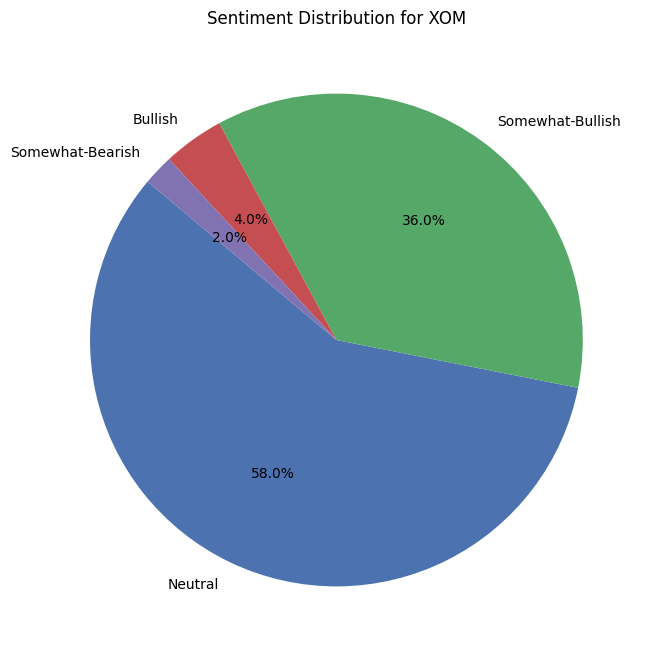

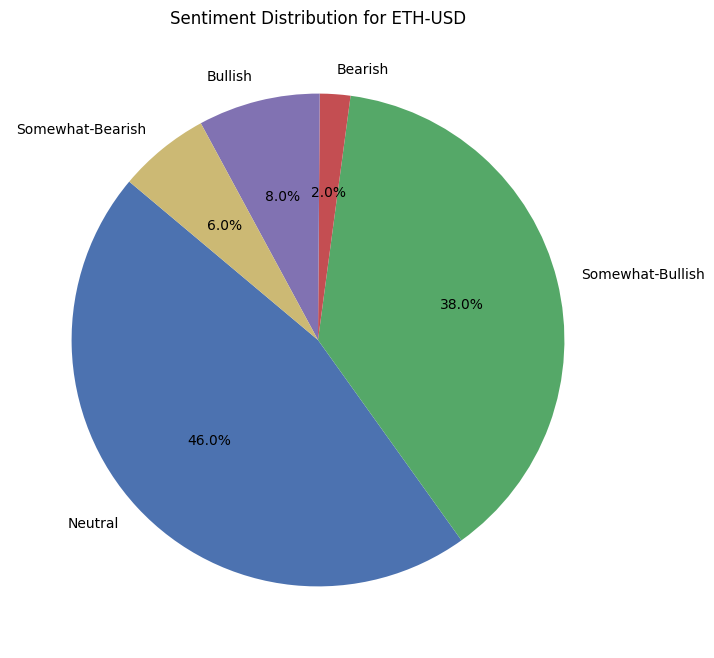

In [268]:
# Open the file for reading
if os.path.isfile("data/sentiments.json"):        
    with open("data/sentiments.json", "r") as sf:
        # Load the dictionary from the file
        sentiments = json.load(sf)
    
    
    # Function to create a pie chart
    def create_pie_chart(symbol, sentiment_list):
        sentiment_counts = Counter(sentiment_list)
        labels = sentiment_counts.keys()
        sizes = sentiment_counts.values()
    
        plt.figure(figsize=(8, 8))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
        plt.title(f'Sentiment Distribution for {symbol}')
        figname = "images/07_" + symbol + "_SentimentVisual.png"
        plt.savefig(figname)
        plt.show()
    
    
    
    # Generate pie charts for each stock symbol
    for symbol, sentiment_list in sentiments.items():
        create_pie_chart(symbol, sentiment_list)

In [269]:
import pandas as pd
import json

# tickers_annual_df = pd.read_json('data/total_annualizedreturn.json')
with open ('data/total_annualizedreturn.json','r') as infile:
    tickers_annual_dict = json.load(infile)



tickers_ann = pd.Series(tickers_annual_dict)




In [270]:

# Calculate expected annualized returns and the sample covariance matrix
mu = tickers_ann
# S = risk_models.sample_cov(data)
S = risk_models.risk_matrix(all_data, returns_data=True, method='ledoit_wolf')



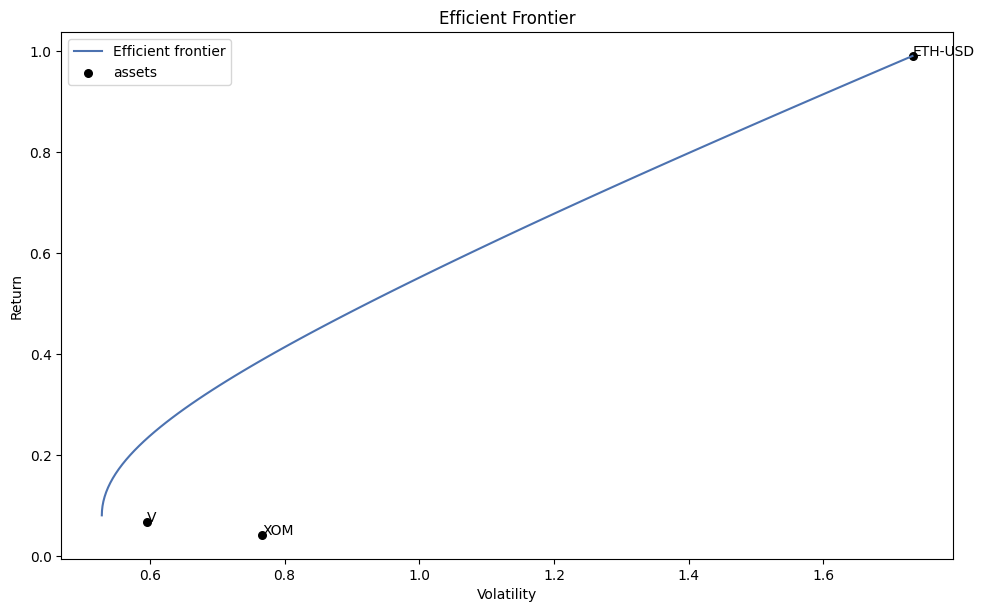

Expected annual return: 99.0%
Annual volatility: 173.2%
Sharpe Ratio: 0.56


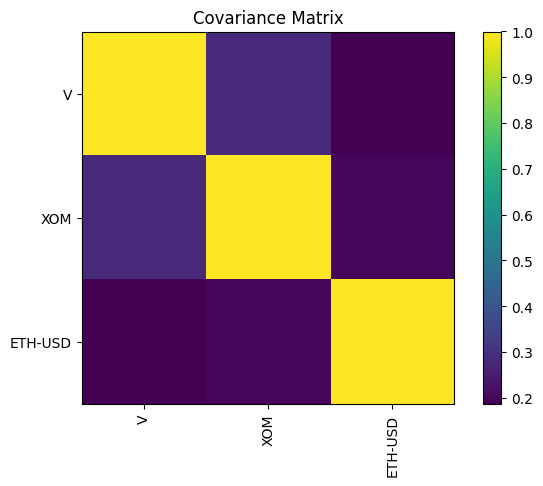

0.9902565449945833
1.7324030987951051
0.5600639629826346


In [271]:
# Initialize the Efficient Frontier object for plotting
ef_plot = EfficientFrontier(mu, S)

# Plot the efficient frontier before solving the optimization problem
fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=True, show_tickers=True)
plt.title('Efficient Frontier')
figname = "images/04_EfficientFrontier.png"
plt.savefig(figname)
plt.show()

# Initialize the Efficient Frontier object for optimization
ef = EfficientFrontier(mu, S)

weights = ef.max_sharpe()
# Calculate the portfolio performance
ret, vol, sharpe = ef.portfolio_performance(verbose=True)

# Plot the covariance matrix
plotting.plot_covariance(S, plot_correlation=True, ax=ax)
plt.title('Covariance Matrix')
figname = "images/02_CovarianceMatrix.png"
plt.savefig(figname)
plt.show()

print(ret)
print(vol)
print(sharpe)



In [272]:
sharpe_2 = sharpe
sharpe_2 = sharpe_2 + .005


In [273]:
string1 = f"Annualized Return: {ret * 100:.2f}%"
string2 = f"Annual Volatility:  {vol * 100:.2f}%"
string3 = f"Sharpe Ratio: {sharpe_2:.2f}"

print(string1)
print(string2)
print(string3)

Annualized Return: 99.03%
Annual Volatility:  173.24%
Sharpe Ratio: 0.57


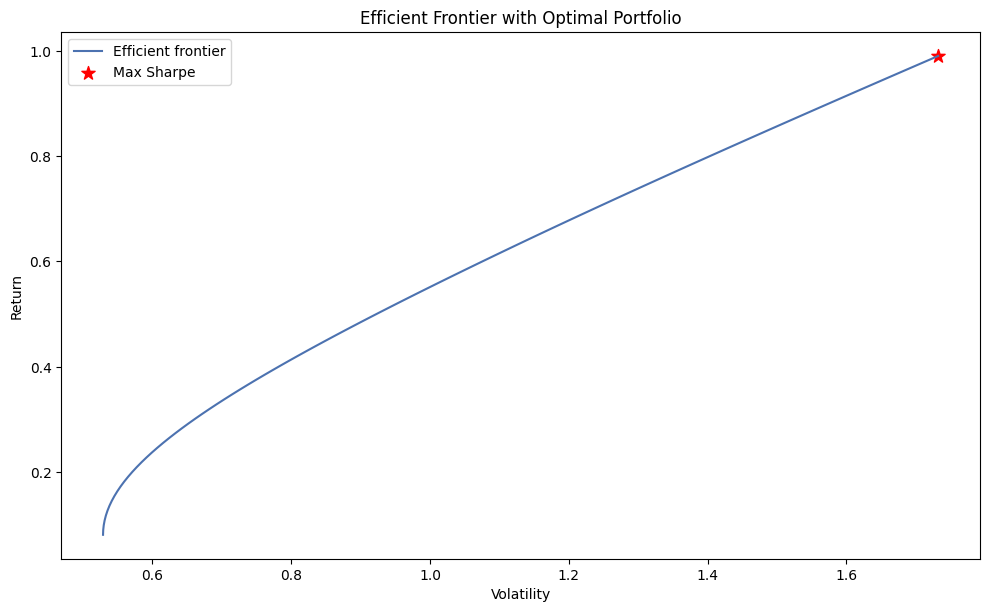

In [274]:
# Reinitialize the Efficient Frontier object for plotting
ef_plot = EfficientFrontier(mu, S)

# Plot the efficient frontier again and mark the optimal portfolio
fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=False)
ax.scatter(vol, ret, marker='*', color='r', s=100, label='Max Sharpe')
plt.title('Efficient Frontier with Optimal Portfolio')
plt.legend()
figname = "images/05_OptimizedEfficientFrontier.png"
plt.savefig(figname)
plt.show()

In [275]:

font_path = "C:\\Windows\\Fonts\\Arial.ttf"
font = ImageFont.truetype(font_path, 28)

img = Image.new('RGB', (500, 250), color='white')
d = ImageDraw.Draw(img)
d.text((20, 20), string1, fill='black', font=font)
d.text((20, 100), string2, fill='black', font=font)
d.text((20, 180), string3, fill='black', font=font)

img.save("images/06_sharpevolret_info.png")